In [1]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from statistics import mean
import impaintingLib as imp

import torchvision
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn as nn

In [2]:
def allDataset():
    datasets = []
    datasets.append(imp.data.getDataset("./data/utk",factorResize=2,doShuffle=True,doCrop=False))
    datasets.append(imp.data.getDataset("./data/flickr",factorResize=2,doShuffle=True,doCrop=False))
    datasets.append(imp.data.getDataset("./data/lfw",factorResize=2,doShuffle=True))
    #datasets.append(imp.data.getDataset("./data/celeba",factorResize=2,doShuffle=True))
    return torch.utils.data.ConcatDataset(datasets)

In [3]:
factorResize = 2
scale_factor = 2
batch_size = 32
runName = "betterUNet"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = imp.model.UNet(5, netType="partial",doubleLayer=True).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
alter = imp.mask.Alter(resize=factorResize,seed=0,test=True).irregularMask # squareMask irregularMask fullMask

# tuples de loss et leur coef
losses = [(torch.nn.L1Loss(),1),
          (imp.loss.perceptualVGG,1),
          (imp.loss.totalVariation,1)]

dataset = allDataset()
print(len(dataset))
#dataset,_ = torch.utils.data.random_split(dataset, [640, len(dataset)-640])
trainloader = DataLoader(dataset, num_workers=2, batch_size=batch_size, shuffle=True)
print(len(trainloader))

#model.load_state_dict(torch.load("./modelSave/train/bestMask_5"))
imp.process.train_inpainting(model, optimizer, trainloader, alter, losses, runName=runName, scale_factor=scale_factor, simplify_seg=True, epochs=30)

89550
2799


Training progress:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2799 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [128, 384, 3, 3], expected input[32, 512, 32, 32] to have 384 channels, but got 512 channels instead

## Test 

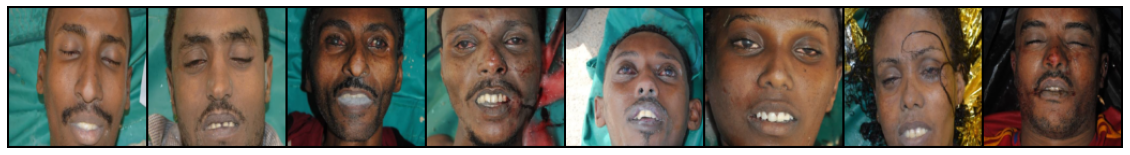

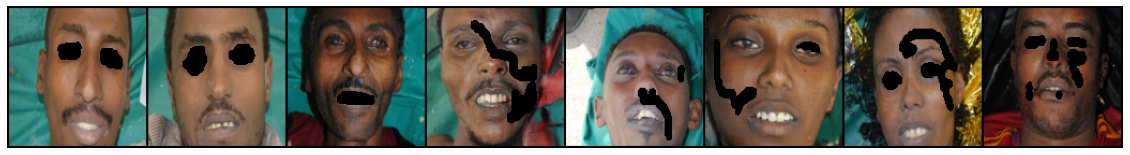

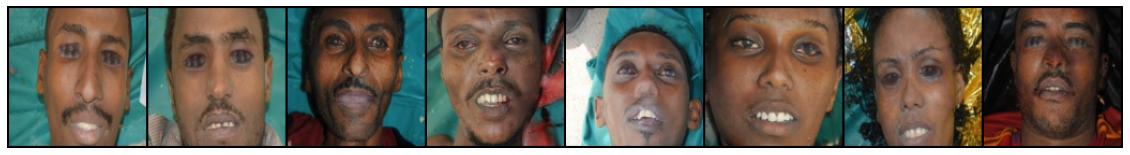

In [5]:
# Impainter
impainter = imp.model.UNet(5, netType="partial").to(device) 
impainter_weight_path = './modelSave/train/bestMask'
impainter.load_state_dict(torch.load(impainter_weight_path))
impainter.eval()
imp.data.testReal(impainter)